In [1]:
import pandas as pd
from lightgbm import LGBMRegressor
import gc
from numerapi import NumerAPI
from halo import Halo
from utils import save_model, load_model, neutralize, get_biggest_change_features, validation_metrics, download_data
from scipy.stats import spearmanr
import numpy as np

In [2]:
public_id = "2NFRGJNS2EDZP7O4AYNPGDNAPBOJ7BQ7"
secret_key = "AZC72J3TMUS2GRY36GMLRR3ZF22A7SYGZLFS4MRFO4GXUXHGQFPIWZ6JPXYSAKZF"
napi = NumerAPI(public_id, secret_key)

In [3]:
#napi = NumerAPI()
spinner = Halo(text='', spinner='dots')

current_round = napi.get_current_round(tournament=8)  # tournament 8 is the primary Numerai Tournament
print(current_round)

# read in all of the new datas
# tournament data and example predictions change every week so we specify the round in their names
# training and validation data only change periodically, so no need to download them over again every single week
napi.download_dataset("numerai_training_data_int8.parquet", "numerai_training_data_int8.parquet")
napi.download_dataset("numerai_tournament_data_int8.parquet", f"numerai_tournament_data_{current_round}_int8.parquet")
napi.download_dataset("numerai_validation_data_int8.parquet", f"numerai_validation_data_int8.parquet")
napi.download_dataset("example_predictions.parquet", f"example_predictions_{current_round}.parquet")
napi.download_dataset("example_validation_predictions.parquet", "example_validation_predictions.parquet")

spinner.start('Reading parquet data')
training_data = pd.read_parquet('numerai_training_data_int8.parquet')
tournament_data = pd.read_parquet(f'numerai_tournament_data_{current_round}_int8.parquet')
validation_data = pd.read_parquet('numerai_validation_data_int8.parquet')
example_preds = pd.read_parquet(f'example_predictions_{current_round}.parquet')
validation_preds = pd.read_parquet('example_validation_predictions.parquet')
spinner.succeed()

EXAMPLE_PREDS_COL = "example_preds"
validation_data[EXAMPLE_PREDS_COL] = validation_preds["prediction"]

TARGET_COL = "target"
ERA_COL = "era"

# all feature columns start with the prefix "feature_"
#feature_cols = [c for c in training_data if c.startswith("feature_")]

gc.collect()

291


2021-11-21 20:37:00,710 INFO numerapi.utils: target file already exists
2021-11-21 20:37:00,725 INFO numerapi.utils: download complete
2021-11-21 20:37:02,252 INFO numerapi.utils: target file already exists
2021-11-21 20:37:02,252 INFO numerapi.utils: download complete
2021-11-21 20:37:03,859 INFO numerapi.utils: target file already exists
2021-11-21 20:37:03,860 INFO numerapi.utils: download complete
2021-11-21 20:37:05,398 INFO numerapi.utils: target file already exists
2021-11-21 20:37:05,398 INFO numerapi.utils: download complete
2021-11-21 20:37:07,158 INFO numerapi.utils: target file already exists
2021-11-21 20:37:07,160 INFO numerapi.utils: download complete


v Reading parquet data


0

In [4]:
f=['feature_haziest_lifelike_horseback', 'feature_glare_factional_assessment', 'feature_exorbitant_myeloid_crinkle', 'feature_travelled_semipermeable_perruquier', 'feature_branched_dilatory_sunbelt', 'feature_moralistic_heartier_typhoid', 'feature_introvert_symphysial_assegai', 'feature_gullable_sanguine_incongruity', 'feature_agile_unrespited_gaucho', 'feature_canalicular_peeling_lilienthal', 'feature_unvaried_social_bangkok', 'feature_lofty_acceptable_challenge', 'feature_grandmotherly_circumnavigable_homonymity', 'feature_undivorced_unsatisfying_praetorium', 'feature_unaired_operose_lactoprotein']
f+=['feature_travelled_semipermeable_perruquier', 'feature_planned_superimposed_bend', 'feature_moralistic_heartier_typhoid', 'feature_crowning_frustrate_kampala', 'feature_unaired_operose_lactoprotein', 'feature_flintier_enslaved_borsch', 'feature_cambial_bigoted_bacterioid', 'feature_jerkwater_eustatic_electrocardiograph', 'feature_unvaried_social_bangkok', 'feature_communicatory_unrecommended_velure', 'feature_lofty_acceptable_challenge', 'feature_grandmotherly_circumnavigable_homonymity', 'feature_antichristian_slangiest_idyllist', 'feature_assenting_darn_arthropod', 'feature_haziest_lifelike_horseback', 'feature_exorbitant_myeloid_crinkle', 'feature_beery_somatologic_elimination', 'feature_silver_handworked_scauper', 'feature_canalicular_peeling_lilienthal', 'feature_undivorced_unsatisfying_praetorium']
f+=['feature_glare_factional_assessment', 'feature_travelled_semipermeable_perruquier', 'feature_moralistic_heartier_typhoid', 'feature_stylistic_honduran_comprador', 'feature_crowning_frustrate_kampala', 'feature_unaired_operose_lactoprotein', 'feature_flintier_enslaved_borsch', 'feature_unvaried_social_bangkok', 'feature_apomictical_motorized_vaporisation', 'feature_lofty_acceptable_challenge', 'feature_antichristian_slangiest_idyllist', 'feature_store_apteral_isocheim', 'feature_unforbidden_highbrow_kafir', 'feature_buxom_curtained_sienna', 'feature_haziest_lifelike_horseback', 'feature_exorbitant_myeloid_crinkle', 'feature_silver_handworked_scauper', 'feature_canalicular_peeling_lilienthal', 'feature_introvert_symphysial_assegai', 'feature_univalve_abdicant_distrail', 'feature_undivorced_unsatisfying_praetorium']
f+=['feature_glare_factional_assessment', 'feature_unsealed_suffixal_babar', 'feature_travelled_semipermeable_perruquier', 'feature_moralistic_heartier_typhoid', 'feature_twisty_adequate_minutia', 'feature_flintier_enslaved_borsch', 'feature_slack_calefacient_tableau', 'feature_bhutan_imagism_dolerite', 'feature_unvaried_social_bangkok', 'feature_communicatory_unrecommended_velure', 'feature_lofty_acceptable_challenge', 'feature_grandmotherly_circumnavigable_homonymity', 'feature_chuffier_analectic_conchiolin', 'feature_antichristian_slangiest_idyllist', 'feature_unwonted_trusted_fixative', 'feature_haziest_lifelike_horseback', 'feature_exorbitant_myeloid_crinkle', 'feature_beery_somatologic_elimination', 'feature_winsome_irreproachable_milkfish', 'feature_gullable_sanguine_incongruity', 'feature_silver_handworked_scauper', 'feature_canalicular_peeling_lilienthal', 'feature_introvert_symphysial_assegai', 'feature_undivorced_unsatisfying_praetorium']

feature_cols = list(set(f))
len(feature_cols)

38

In [5]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
# # def correlation_score(y_true, y_pred):
# #     return np.corrcoef(y_true, y_pred)[0,1]

# The models should be scored based on the rank-correlation (spearman) with the target
def spearman_score(y_true, y_pred):
    rank_pred = y_pred.rank(pct=True, method="first")
    return np.corrcoef(y_true, rank_pred)[0,1]

# def spearman(y_true, y_pred): 
#     return spearmanr(y_pred, y_true).correlation

Fix tournament NaNs

In [6]:
# check for nans and fill nans
if tournament_data.loc[tournament_data["data_type"] == "live", feature_cols].isna().sum().sum():
    cols_w_nan = tournament_data.loc[tournament_data["data_type"] == "live", feature_cols].isna().sum()
    total_rows = tournament_data[tournament_data["data_type"] == "live"]
    print(f"Number of nans per column this week: {cols_w_nan[cols_w_nan > 0]}")
    print(f"out of {total_rows} total rows")
    print(f"filling nans with 2.0")
    tournament_data.loc[:, feature_cols].fillna(2.0, inplace=True)
else:
    print("No nans in the features this week!")

No nans in the features this week!


In [7]:
def create_lgbm_regressor(model_name:str):
    model = load_model(model_name)
    if not model:
        print(f"model not found, training new one")
        params = {"n_estimators": 2000,
                "learning_rate": 0.01,
                "max_depth": 5,
                "num_leaves": 2 ** 5,
                "colsample_bytree": 0.1}

        model = LGBMRegressor(**params)

        # train on all of train, predict on val, predict on tournament, save the model so we don't have to train next time
        spinner.start('Training model')
        model.fit(training_data.loc[:, feature_cols], training_data[TARGET_COL])
        print(f"saving new model: {model_name}")
        save_model(model, model_name)
        spinner.succeed()

    return model

In [8]:
def save_prediction(model, model_name, neutralize_proportion = 0.8, is_xgbRanker = False, use_pool = False):
    spinner.start('Predicting on latest data')
    # double check the feature that the model expects vs what is available
    # this prevents our pipeline from failing if Numerai adds more data and we don't have time to retrain!


    try:
        model_expected_features = model.booster_.feature_name()
    except:
        try:
            model_expected_features = model.get_booster().feature_names
        except:
            model_expected_features = model.feature_names_
        
    if set(model_expected_features) != set(feature_cols):
        print(f"New features are available! Might want to retrain model {model_name}.")

    if not use_pool:
        # if is_xgbRanker:
            
        #     for era in validation_data.era.unique():
        #         print(f"predicting valid era:{era}")
        #         validation_data.loc[validation_data.era == era, f"preds_{model_name}"] = \
        #             model.predict(validation_data.loc[validation_data.era == era, model_expected_features])

        #     for era in tournament_data.era.unique():
        #         print(f"predicting tournament era:{era}")
        #         tournament_data.loc[tournament_data.era == era, f"preds_{model_name}"] = \
        #             model.predict(tournament_data.loc[tournament_data.era == era, model_expected_features])
        # else:
        validation_data.loc[:, f"preds_{model_name}"] = model.predict(validation_data.loc[:, model_expected_features])
        tournament_data.loc[:, f"preds_{model_name}"] = model.predict(tournament_data.loc[:, model_expected_features])
    else:
        #catboost ranker is not compayible with sklearn

        test_pool = Pool(
            data=validation_data.loc[:, feature_cols],
            label=validation_data[TARGET_COL],
            group_id=validation_data.era
        )
        validation_data.loc[:, f"preds_{model_name}"] = model.predict(test_pool)

        tournament_pool = Pool (
            data = tournament_data.loc[:, model_expected_features],
            group_id = tournament_data.era
        )

        tournament_data.loc[:, f"preds_{model_name}"] = model.predict(tournament_pool)

    spinner.succeed()

    spinner.start('Neutralizing to risky features')
    # getting the per era correlation of each feature vs the target
    all_feature_corrs = training_data.groupby(ERA_COL).apply(lambda d: d[feature_cols].corrwith(d[TARGET_COL]))

    # find the riskiest features by comparing their correlation vs the target in half 1 and half 2 of training data
    riskiest_features = get_biggest_change_features(all_feature_corrs, 50)

    # neutralize our predictions to the riskiest features
    validation_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(df=validation_data,
                                                                            columns=[f"preds_{model_name}"],
                                                                            neutralizers=riskiest_features,
                                                                            proportion=neutralize_proportion,
                                                                            normalize=True,
                                                                            era_col=ERA_COL)

    tournament_data[f"preds_{model_name}_neutral_riskiest_50"] = neutralize(df=tournament_data,
                                                                            columns=[f"preds_{model_name}"],
                                                                            neutralizers=riskiest_features,
                                                                            proportion=neutralize_proportion,
                                                                            normalize=True,
                                                                            era_col=ERA_COL)
    spinner.succeed()

    model_to_submit = f"preds_{model_name}_neutral_riskiest_50"

    # rename best model to prediction and rank from 0 to 1 to meet diagnostic/submission file requirements
    validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True, method="first")
    tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True, method="first")
    validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
    tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")

    # get some stats about each of our models to compare...
    # fast_mode=True so that we skip some of the stats that are slower to calculate
    validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
    print(validation_stats[["mean", "sharpe"]].to_markdown())

In [9]:
#Blitter4 XGBRank
from xgboost import XGBRanker
from collections import Counter


def create_xgb_ranker(model_name:str):
    model = load_model(model_name)
    if not model:
        print(f"model not found, training new one")

                        
        model = XGBRanker(max_depth=5, learning_rate=0.01, n_estimators=2000, n_jobs=-1, colsample_bytree=0.1)
        # cdf = training_data.groupby('era').agg(['count'])
        # group = cdf[cdf.columns[0]].values
        # del cdf
        group = Counter(training_data.era).values()

        # train on all of train, predict on val, predict on tournament, save the model so we don't have to train next time
        spinner.start('Training model')
        model.fit(training_data.loc[:, feature_cols], training_data[TARGET_COL], group=group)
        print(f"saving new model: {model_name}")
        save_model(model, model_name)
        spinner.succeed()

    return model

In [10]:
from xgboost import XGBRegressor

def create_xgb_regressor(model_name:str):
    model = load_model(model_name)
    if not model:
        print(f"model not found, training new one")
        params = {"n_estimators": 2000,
                "learning_rate": 0.01,
                "max_depth": 5,
                "num_leaves": 2 ** 5,
                "colsample_bytree": 0.1}

        model = XGBRegressor(max_depth=5, learning_rate=0.01, \
                        n_estimators=2000, colsample_bytree=0.1) #provar regularitzacions

        # train on all of train, predict on val, predict on tournament, save the model so we don't have to train next time
        spinner.start('Training model')
        model.fit(training_data.loc[:, feature_cols], training_data[TARGET_COL])
        print(f"saving new model: {model_name}")
        save_model(model, model_name)
        spinner.succeed()

    return model

In [11]:
#blitter5 - Catboost regressor
from catboost import CatBoostRegressor

def create_catboost_regressor(model_name:str):

    model = load_model(model_name)
    if not model:
        print(f"model not found, training new one")

        model = CatBoostRegressor(max_depth=5, learning_rate=0.01, \
                        n_estimators=2000, rsm=0.1) #provar regularitzacions

        # train on all of train, predict on val, predict on tournament, save the model so we don't have to train next time
        spinner.start('Training model')
        model.fit(training_data.loc[:, feature_cols], training_data[TARGET_COL])
        print(f"saving new model: {model_name}")
        save_model(model, model_name)
        spinner.succeed()

    return model

In [12]:
from catboost import CatBoostRanker, Pool

def create_catboost_ranker(model_name : str, loss_function : str, plot = True, verbose = False):
    gc.collect()
    print(f"predicting {model_name}")
    model = load_model(model_name)
    if not model:
        print(f"model not found, training new one")
        parameters = {
            'iterations': 200,
            'custom_metric': ['NDCG', 'PFound'],
            'verbose': verbose,
            'random_seed': 0,
            'rsm' : 0.1,
            'learning_rate' : 0.01,
            'loss_function' : loss_function,
            #'train_dir' : loss_function
        }

        train_pool = Pool(
            data=training_data.loc[:, feature_cols],
            label=training_data[TARGET_COL],
            group_id=training_data.era
        )

        test_pool = Pool(
            data=validation_data.loc[:, feature_cols],
            label=validation_data[TARGET_COL],
            group_id=validation_data.era
        )

        model = CatBoostRanker(**parameters)


        # train on all of train, predict on val, predict on tournament, save the model so we don't have to train next time
        #spinner.start('Training model')
        model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=10, plot=plot)

        print(f"saving new model: {model_name}")
        save_model(model, model_name)
        #spinner.succeed()

    return model

In [13]:
def submit_model(model_name : str):
    model_id = napi.get_models()[model_name]
    model_to_submit = f"preds_{model_name}_neutral_riskiest_50"
    napi.upload_predictions(f"tournament_predictions_{current_round}_{model_to_submit}.csv", model_id=model_id)

In [14]:
model_name = f"blitter"
model = create_lgbm_regressor(model_name)
save_prediction(model, model_name)

v Predicting on latest data
v Neutralizing to risky features
|                                   |      mean |   sharpe |
|:----------------------------------|----------:|---------:|
| preds_blitter_neutral_riskiest_50 | 0.0228259 |  1.05479 |


In [15]:
model_name = "blitter1" #f"xgboost_bare"
model = create_xgb_regressor(model_name)
save_prediction(model, model_name)


v Predicting on latest data
v Neutralizing to risky features
|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter1_neutral_riskiest_50 | 0.0241834 |  1.04763 |


In [16]:
#Ensemble Lgbm + XGBoost ja neutralitzzades
model_name = "blitter2"

validation_data.loc[:, f"preds_{model_name}"] = validation_data["preds_blitter_neutral_riskiest_50"] * 0.5 + validation_data["preds_blitter1_neutral_riskiest_50"] * 0.5
tournament_data.loc[:, f"preds_{model_name}"] = tournament_data["preds_blitter_neutral_riskiest_50"] * 0.5 + tournament_data["preds_blitter1_neutral_riskiest_50"] * 0.5

model_to_submit = f"preds_{model_name}_neutral_riskiest_50"

validation_data[model_to_submit] = validation_data[f"preds_{model_name}"]
tournament_data[model_to_submit] = tournament_data[f"preds_{model_name}"]


# rename best model to prediction and rank from 0 to 1 to meet diagnostic/submission file requirements
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True, method="first")
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True, method="first")

validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())




|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter2_neutral_riskiest_50 | 0.0239164 |  1.06938 |


In [17]:
#Ensemble Lgbm + XGBoost ensemble after rank and xgboost half weight
model_name = "blitter3"

#ensemble on ranks
validation_data.loc[:, f"preds_{model_name}"] = validation_data["preds_blitter_neutral_riskiest_50"].rank(pct=True, method="first") + validation_data["preds_blitter1_neutral_riskiest_50"].rank(pct=True, method="first") / 2
tournament_data.loc[:, f"preds_{model_name}"] = tournament_data["preds_blitter_neutral_riskiest_50"].rank(pct=True, method="first") + tournament_data["preds_blitter1_neutral_riskiest_50"].rank(pct=True, method="first") / 2

model_to_submit = f"preds_{model_name}"

#rank again to fix decimals coming from the /2
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True, method="first")
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())



|                |      mean |   sharpe |
|:---------------|----------:|---------:|
| preds_blitter3 | 0.0236422 |  1.06787 |


In [18]:
model_name = f"blitter4"
model = create_xgb_ranker(model_name)
save_prediction(model, model_name, is_xgbRanker= False)



v Predicting on latest data
v Neutralizing to risky features
|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter4_neutral_riskiest_50 | 0.0217392 | 0.864442 |


In [19]:
model_name = f"blitter5"
model = create_catboost_regressor(model_name)
save_prediction(model, model_name)



v Predicting on latest data
v Neutralizing to risky features
|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter5_neutral_riskiest_50 | 0.0233501 | 0.975429 |


In [20]:
model_name = f"blitter6"
loss_function = "QueryRMSE"
model = create_catboost_ranker(model_name, loss_function)
save_prediction(model, model_name, use_pool =True)



predicting blitter6
v Predicting on latest data
v Neutralizing to risky features
|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter6_neutral_riskiest_50 | 0.0173495 | 0.855442 |


In [21]:
model_name = f"blitter7"
loss_function = "PairLogit:max_pairs=100000"

model = create_catboost_ranker(model_name, loss_function)
save_prediction(model, model_name, use_pool =True)


predicting blitter7
v Predicting on latest data
v Neutralizing to risky features
|                                    |      mean |   sharpe |
|:-----------------------------------|----------:|---------:|
| preds_blitter7_neutral_riskiest_50 | 0.0147554 | 0.726437 |


In [22]:
model_name = "blitter8"
#Ensemble equal weights blitter (lgbm)+blitter1(xgb)+blitter4(xgb rank)+blitter5(catboost)
#ensemble on ranks
validation_data.loc[:, f"preds_{model_name}"] = (
    validation_data["preds_blitter_neutral_riskiest_50"].rank(pct=True, method="first") 
    + validation_data["preds_blitter1_neutral_riskiest_50"].rank(pct=True, method="first")
    + validation_data["preds_blitter4_neutral_riskiest_50"].rank(pct=True, method="first")
    + validation_data["preds_blitter5_neutral_riskiest_50"].rank(pct=True, method="first")
) / 4

tournament_data.loc[:, f"preds_{model_name}"] = (
    tournament_data["preds_blitter_neutral_riskiest_50"].rank(pct=True, method="first") 
    + tournament_data["preds_blitter1_neutral_riskiest_50"].rank(pct=True, method="first")
    + tournament_data["preds_blitter4_neutral_riskiest_50"].rank(pct=True, method="first")
    + tournament_data["preds_blitter5_neutral_riskiest_50"].rank(pct=True, method="first")
) / 4


model_to_submit = f"preds_{model_name}"

#rank again to fix decimals coming from the /2
validation_data["prediction"] = validation_data[model_to_submit].rank(pct=True, method="first")
tournament_data["prediction"] = tournament_data[model_to_submit].rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())




|                |      mean |   sharpe |
|:---------------|----------:|---------:|
| preds_blitter8 | 0.0237905 |  1.00593 |


In [23]:
from functools import partial  
from scipy.optimize import fmin 
from sklearn import metrics

class OptimizeSpearman:  
    """ 
    Class for optimizing AUC.  
    This class is all you need to find best weights for  any model and for any metric and for any types of predictions.  
    With very small changes, this class can be used for optimization of  weights in ensemble models of _any_ type of predictions 
    """  
    def __init__(self):  
        self.coef_  = 0  
        
    def _auc(self, coef, X, y):  
        """  
        This functions calculates and returns AUC.  
        :param coef: coef list, of the same length as number of models  
        :param X: predictions, in this case a 2d array  
        :param y: targets, in our case binary 1d array  
        """  
        # multiply coefficients with every column of the array  #with predictions.  
        # this means: element 1 of coef is multiplied by column 1  
        # of the prediction array, element 2 of coef is multiplied  
        # #by column 2 of the prediction array and so on!  
        x_coef = X * coef  
        # create predictions by taking row wise sum  
        predictions = np.sum(x_coef, axis=1)  
        #calculate auc score  
        #auc_score = metrics.roc_auc_score(y, predictions) 
        #auc_score = correlation_score(y, predictions)
        auc_score = spearman_score(y, predictions)
        #return negative auc  
        return -1.0 * auc_score  
        
    def fit(self, X, y):  
        #remember partial from hyperparameter optimization chapter?  
        loss_partial = partial(self._auc, X=X, y=y)  
        #dirichlet distribution. you can use any distribution you want  
        #to initialize the coefficients
        #we want the coefficients to sum to 1  
        initial_coef = np.random.dirichlet(np.ones(X.shape[1]), size=1)  
        #use scipy fmin to minimize the loss function, in our case auc 
        self.coef_ = fmin(loss_partial, initial_coef, disp=True) 

    def predict(self, X): 
        #this is similar to  _auc function 
        x_coef = X * self.coef_ 
        predictions = np.sum(x_coef, axis=1)  
        return predictions

array([[<AxesSubplot:title={'center':'preds_blitter_neutral_riskiest_50'}>,
        <AxesSubplot:title={'center':'preds_blitter1_neutral_riskiest_50'}>],
       [<AxesSubplot:title={'center':'preds_blitter4_neutral_riskiest_50'}>,
        <AxesSubplot:title={'center':'preds_blitter5_neutral_riskiest_50'}>]],
      dtype=object)

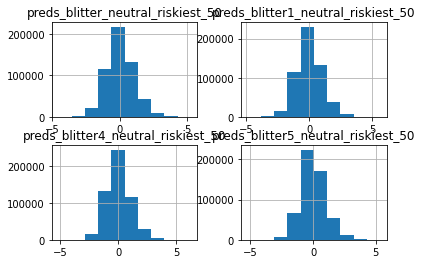

In [24]:
#blitter 9 - Optimize weights to validation
# overfitting???
model_name = "blitter9"
pred_cols = ["preds_blitter_neutral_riskiest_50", "preds_blitter1_neutral_riskiest_50", "preds_blitter4_neutral_riskiest_50", "preds_blitter5_neutral_riskiest_50"]
validation_data[pred_cols].hist()


In [25]:
validation_data[pred_cols]

,preds_blitter_neutral_riskiest_50,preds_blitter1_neutral_riskiest_50,preds_blitter4_neutral_riskiest_50,preds_blitter5_neutral_riskiest_50
id,,,,
n000777698096000,-1.368495,-1.013497,-0.861677,-1.177945
n0009793a3b91c27,-0.152977,-0.322543,-0.027273,-0.343071
n00099ccd6698ab0,0.953908,0.994762,1.107778,0.636381
n0019e36bbb8702b,1.161369,0.619289,0.854011,0.967999
n0028cb874439df8,-0.564193,-0.760749,-1.247439,-0.640046
...,...,...,...,...
nffbe5152c321f92,0.928807,1.227650,0.756973,1.709305
nffc011b4baa54c3,-0.957114,-0.912438,-1.293410,-0.483725
nffc12b2a846ab4e,-0.009302,0.529602,0.311594,0.457145


In [26]:
validation_data[pred_cols].rank(pct=True, method="first")

,preds_blitter_neutral_riskiest_50,preds_blitter1_neutral_riskiest_50,preds_blitter4_neutral_riskiest_50,preds_blitter5_neutral_riskiest_50
id,,,,
n000777698096000,0.069744,0.137987,0.179970,0.095644
n0009793a3b91c27,0.450131,0.380921,0.510668,0.369215
n00099ccd6698ab0,0.834043,0.842704,0.862198,0.760070
n0019e36bbb8702b,0.874534,0.748202,0.808998,0.840460
n0028cb874439df8,0.279657,0.211877,0.086785,0.248140
...,...,...,...,...
nffbe5152c321f92,0.828449,0.885644,0.785042,0.942628
nffc011b4baa54c3,0.152673,0.164651,0.078661,0.309042
nffc12b2a846ab4e,0.512313,0.720621,0.645968,0.704242


In [27]:
model_to_submit = f"preds_{model_name}"
opt = OptimizeSpearman()
#opt.fit(validation_data[pred_cols], validation_data[TARGET_COL])
opt.fit(validation_data[pred_cols].rank(pct=True, method="first"), validation_data[TARGET_COL])
opt_valid = opt.predict(validation_data[pred_cols])
opt_preds = opt.predict(tournament_data[pred_cols]) 

Optimization terminated successfully.
         Current function value: -0.024786
         Iterations: 100
         Function evaluations: 189


In [28]:



#rank again to fix decimals coming from the /2
validation_data["prediction"] = opt_valid.rank(pct=True, method="first")
tournament_data["prediction"] = opt_preds.rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")
validation_data.loc[:, model_to_submit] = opt_valid #ojo a les stats es passa sense rankejar?

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())


#  preds_blitter12 | 0.024994 |  1.08523 |

|                |      mean |   sharpe |
|:---------------|----------:|---------:|
| preds_blitter9 | 0.0247333 |  1.11858 |


In [29]:
opt.coef_

array([-0.02912364,  0.5983752 , -0.2650712 ,  0.15833223])

Optimization terminated successfully.
         Current function value: -0.024403
         Iterations: 51
         Function evaluations: 111
|                 |      mean |   sharpe |
|:----------------|----------:|---------:|
| preds_blitter10 | 0.0242849 |  1.03779 |


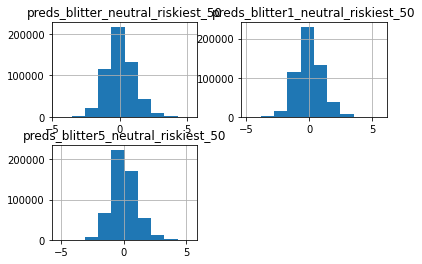

In [30]:
#blitter10 - only 3 / lgbm xgb cb
#Optimize weights to validation
# overfitting???
model_name = "blitter10"
pred_cols = ["preds_blitter_neutral_riskiest_50", "preds_blitter1_neutral_riskiest_50", "preds_blitter5_neutral_riskiest_50"]
validation_data[pred_cols].hist()
model_to_submit = f"preds_{model_name}"
opt = OptimizeSpearman()
#opt.fit(validation_data[pred_cols], validation_data[TARGET_COL])
opt.fit(validation_data[pred_cols].rank(pct=True, method="first"), validation_data[TARGET_COL])
opt_valid = opt.predict(validation_data[pred_cols])
opt_preds = opt.predict(tournament_data[pred_cols]) 
#rank again to fix decimals coming from the /2
validation_data["prediction"] = opt_valid.rank(pct=True, method="first")
tournament_data["prediction"] = opt_preds.rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")
validation_data.loc[:, model_to_submit] = opt_valid #ojo a les stats es passa sense rankejar?

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())



In [31]:
opt.coef_

array([0.00660862, 0.51477131, 0.18053702])

In [32]:
#aquest es el lgbm reentrenat que dona millor corr, pitjor mmc, i em fa baixar teoricament els ensembles
model_name = f"blitter11"
model = create_lgbm_regressor(model_name)
save_prediction(model, model_name)



v Predicting on latest data
v Neutralizing to risky features
|                                     |     mean |   sharpe |
|:------------------------------------|---------:|---------:|
| preds_blitter11_neutral_riskiest_50 | 0.024424 |   1.0086 |


Optimization terminated successfully.
         Current function value: -0.025080
         Iterations: 98
         Function evaluations: 184
|                 |      mean |   sharpe |
|:----------------|----------:|---------:|
| preds_blitter12 | 0.0250167 |  1.10495 |


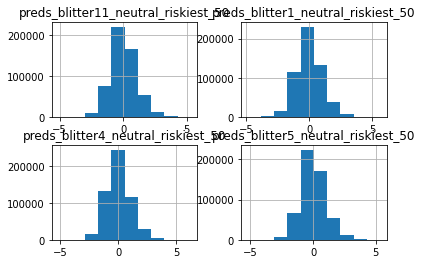

In [33]:
#Optimize weights to validation
# overfitting??? lgb new, xgb, xgb rank, catboost
model_name = "blitter12"
pred_cols = ["preds_blitter11_neutral_riskiest_50", "preds_blitter1_neutral_riskiest_50", "preds_blitter4_neutral_riskiest_50", "preds_blitter5_neutral_riskiest_50"]
validation_data[pred_cols].hist()
model_to_submit = f"preds_{model_name}"
opt = OptimizeSpearman()
#opt.fit(validation_data[pred_cols], validation_data[TARGET_COL])
opt.fit(validation_data[pred_cols].rank(pct=True, method="first"), validation_data[TARGET_COL])
opt_valid = opt.predict(validation_data[pred_cols])
opt_preds = opt.predict(tournament_data[pred_cols]) 
#rank again to fix decimals coming from the /2
validation_data["prediction"] = opt_valid.rank(pct=True, method="first")
tournament_data["prediction"] = opt_preds.rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")
validation_data.loc[:, model_to_submit] = opt_valid #ojo a les stats es passa sense rankejar?

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())



In [34]:
opt.coef_

array([ 0.73176914,  1.41600676, -0.79737961,  0.23179048])

Optimization terminated successfully.
         Current function value: -0.025111
         Iterations: 280
         Function evaluations: 489
|                 |      mean |   sharpe |
|:----------------|----------:|---------:|
| preds_blitter13 | 0.0250243 |  1.09455 |


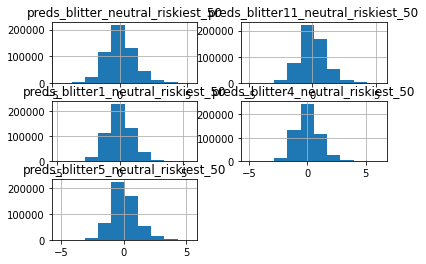

In [35]:
#Optimize weights to validation
# overfitting??? lgb old, lgb new, xgb, xgb rank, catboost
model_name = "blitter13"
pred_cols = ["preds_blitter_neutral_riskiest_50","preds_blitter11_neutral_riskiest_50", "preds_blitter1_neutral_riskiest_50", "preds_blitter4_neutral_riskiest_50", "preds_blitter5_neutral_riskiest_50"]
validation_data[pred_cols].hist()
model_to_submit = f"preds_{model_name}"
opt = OptimizeSpearman()
#opt.fit(validation_data[pred_cols], validation_data[TARGET_COL])
opt.fit(validation_data[pred_cols].rank(pct=True, method="first"), validation_data[TARGET_COL])
opt_valid = opt.predict(validation_data[pred_cols])
opt_preds = opt.predict(tournament_data[pred_cols]) 
#rank again to fix decimals coming from the /2
validation_data["prediction"] = opt_valid.rank(pct=True, method="first")
tournament_data["prediction"] = opt_preds.rank(pct=True, method="first")


validation_data["prediction"].to_csv(f"validation_predictions_{model_to_submit}.csv")
tournament_data["prediction"].to_csv(f"tournament_predictions_{current_round}_{model_to_submit}.csv")
validation_data.loc[:, model_to_submit] = opt_valid #ojo a les stats es passa sense rankejar?

validation_stats = validation_metrics(validation_data, [model_to_submit], example_col=EXAMPLE_PREDS_COL, fast_mode=True)
print(validation_stats[["mean", "sharpe"]].to_markdown())

# TODO GroupKfold for non overlapping eras
# optuna optimize

# stacking

LTR over slightly neutralized target